In [ ]:
# Verificar que el archivo está en el entorno
import os

print(os.listdir("/content"))


['.config', 'dataset__athletia.csv', '.ipynb_checkpoints', 'sample_data']


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

np.random.seed(42)
tf.random.set_seed(42)

print("✅ Librerías cargadas")


✅ Librerías cargadas


In [ ]:
DATA_PATH = "/content/dataset__athletia.csv"

data = pd.read_csv(DATA_PATH)
print("Shape:", data.shape)
print(data.head(3))
print(data["rutina_recomendada"].value_counts())


Shape: (200000, 25)
   edad   imc  ritmo_cardiaco  duracion_min  calorias_quemadas  altura_cm  \
0    31  27.4              90            45                298      168.6   
1    16  22.3              67            75                509      165.7   
2    27  31.4              62            45                363      159.4   

   peso_kg  grasa_corporal  masa_muscular  cintura_cm  ...    horas_dormidas  \
0     77.8            21.2           32.3        76.9  ...    Más de 8 horas   
1     61.1             9.3           22.3        81.5  ...  Menos de 5 horas   
2     79.9            19.4           32.6        72.4  ...    Más de 8 horas   

  calidad_sueno    tipo_comida_principal calorias_diarias_aprox  \
0     Excelente        Alta en proteínas       1500 - 2000 kcal   
1     Excelente  Rápida o ultraprocesada       Más de 2500 kcal   
2         Buena     Vegetariana / Vegana     Menos de 1500 kcal   

  consumo_proteinas meta_peso_corporal meta_grasa_corporal  \
0          Muy bajo

In [ ]:
target_col = "rutina_recomendada"

# Features / target
X = data.drop(columns=[target_col])
y = data[target_col]

# Columnas numéricas
num_cols = [
    "edad",
    "imc",
    "ritmo_cardiaco",
    "duracion_min",
    "calorias_quemadas",
    "altura_cm",
    "peso_kg",
    "grasa_corporal",
    "masa_muscular",
    "cintura_cm",
    "cadera_cm",
]

# Columnas categóricas
cat_cols = [
    "fuma", "bebe", "lesiones_actuales", "enfermedades_preexistentes",
    "horas_dormidas", "calidad_sueno",
    "tipo_comida_principal", "calorias_diarias_aprox", "consumo_proteinas",
    "meta_peso_corporal", "meta_grasa_corporal",
    "objetivo", "nivel_experiencia"
]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)


Numéricas: ['edad', 'imc', 'ritmo_cardiaco', 'duracion_min', 'calorias_quemadas', 'altura_cm', 'peso_kg', 'grasa_corporal', 'masa_muscular', 'cintura_cm', 'cadera_cm']
Categóricas: ['fuma', 'bebe', 'lesiones_actuales', 'enfermedades_preexistentes', 'horas_dormidas', 'calidad_sueno', 'tipo_comida_principal', 'calorias_diarias_aprox', 'consumo_proteinas', 'meta_peso_corporal', 'meta_grasa_corporal', 'objetivo', 'nivel_experiencia']


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(label_encoder.classes_)
print("Clases:", label_encoder.classes_)
print("Número de clases:", num_classes)


Clases: ['Cardio suave' 'Fuerza avanzada' 'Fuerza y pesas' 'Full Body Workout'
 'Funcional' 'HIIT' 'Hipertrofia' 'Pilates' 'Rehabilitación' 'Yoga']
Número de clases: 10


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (160000, 24) Test: (40000, 24)


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Ajustar con train y transformar
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Dimensión entrada (post-preprocesamiento):", X_train_proc.shape[1])


Dimensión entrada (post-preprocesamiento): 70


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

input_dim = X_train_proc.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,514 (240.29 KB)

 Trainable params: 60,746 (237.29 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_proc,
    y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5909 - loss: 1.1161 - val_accuracy: 0.7485 - val_loss: 0.3951
Epoch 2/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7456 - loss: 0.4114 - val_accuracy: 0.7462 - val_loss: 0.3825
Epoch 3/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7476 - loss: 0.3922 - val_accuracy: 0.7462 - val_loss: 0.3801
Epoch 4/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7471 - loss: 0.3868 - val_accuracy: 0.7456 - val_loss: 0.3799
Epoch 5/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7506 - loss: 0.3832 - val_accuracy: 0.7474 - val_loss: 0.3794
Epoch 6/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7476 - loss: 0.3824 - val_accuracy: 0.7476 - val_loss: 0.3784
Epoch 7/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7485 - loss: 0.3809 - val_accuracy: 0.7491 - val_loss: 0.3786
Epoch 8/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7501 - loss: 0.3798 - val_accuracy: 0.

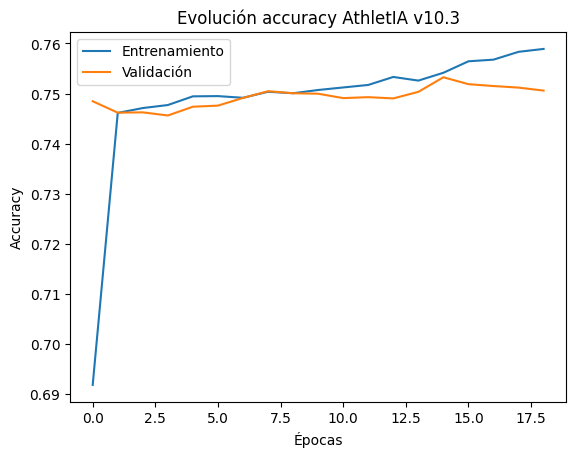

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución accuracy AthletIA v10.3')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
y_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy test: {acc*100:.2f}%")
print(f"✅ F1-weighted: {f1*100:.2f}%")

print("\n📊 Classification report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


✅ Accuracy test: 74.69%
✅ F1-weighted: 74.19%

📊 Classification report:
                   precision    recall  f1-score   support

     Cardio suave       0.47      0.52      0.49      1546
  Fuerza avanzada       0.91      1.00      0.95        87
   Fuerza y pesas       0.54      0.30      0.39       164
Full Body Workout       0.82      0.74      0.78      7917
        Funcional       0.37      0.41      0.39      2161
             HIIT       0.50      0.35      0.41      2107
      Hipertrofia       0.53      0.73      0.62       171
          Pilates       0.47      0.75      0.58      5076
   Rehabilitación       1.00      1.00      1.00     16328
             Yoga       0.50      0.27      0.35      4443

         accuracy                           0.75     40000
        macro avg       0.61      0.61      0.60     40000
     weighted avg       0.76      0.75      0.74     40000



In [ ]:
import joblib

# Rutas de guardado
MODEL_PATH = "/content/athletia_recomendador.keras"
PREPROC_PATH = "/content/preprocessor_athletia.pkl"
ENCODER_PATH = "/content/label_encoder_athletia.pkl"

# Guardar modelo IA
model.save(MODEL_PATH)

# Guardar el preprocesador y codificador de etiquetas
joblib.dump(preprocessor, PREPROC_PATH)
joblib.dump(label_encoder, ENCODER_PATH)

print("✅ Guardado completado con éxito:")
print(MODEL_PATH)
print(PREPROC_PATH)
print(ENCODER_PATH)


✅ Guardado completado con éxito:
/content/athletia_recomendador.keras
/content/preprocessor_athletia.pkl
/content/label_encoder_athletia.pkl


In [ ]:
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)

N = 200_000

OBJETIVOS = [
    "Ganar masa muscular",
    "Reducir grasa corporal",
    "Mejorar rendimiento",
    "Tonificar y definir",
    "Rehabilitación o recuperación",
    "Mantener peso actual",
    "Incrementar fuerza máxima",
    "Optimizar resistencia cardiovascular",
    "Aumentar flexibilidad y movilidad",
    "Salud general y bienestar",
]

NIVELES = ["Principiante", "Intermedio", "Avanzado"]
LESIONES = ["No tengo lesiones", "Lesión de hombro", "Lesión de rodilla", "Esguince", "Desgarro muscular", "Otra lesión leve"]
ENFERMEDADES = ["No poseo", "Asma", "Diabetes", "Hipertensión", "Problemas cardíacos", "Otra enfermedad crónica"]
HORAS_DORMIDAS = ["Menos de 5 horas", "5 a 6 horas", "7 a 8 horas (óptimo)", "Más de 8 horas"]
CALIDAD_SUENO = ["Mala", "Regular", "Buena", "Excelente"]
TIPO_COMIDA = ["Alta en proteínas", "Balanceada", "Alta en carbohidratos", "Alta en grasas", "Vegetariana / Vegana", "Rápida o ultraprocesada"]
CALORIAS_DIARIAS = ["Menos de 1500 kcal", "1500 - 2000 kcal", "2000 - 2500 kcal", "Más de 2500 kcal"]
CONSUMO_PROT = ["Muy bajo", "Moderado", "Alto (según objetivos)"]
META_PESO = ["Subir 1-3 kg", "Subir 4-6 kg", "Bajar 1-3 kg", "Bajar 4-6 kg", "Mantener peso actual"]
META_GRASA = ["Menos del 10%", "Entre 10% y 15%", "Entre 16% y 20%", "Más del 20%"]

RUTINAS = [
    "Fuerza avanzada", "Fuerza y pesas", "Hipertrofia", "Full Body Workout",
    "Funcional", "HIIT", "Cardio suave", "Yoga", "Pilates", "Rehabilitación"
]

# ----------------------------------------------------------------
# FUNCIONES DE LÓGICA FUERTE
# ----------------------------------------------------------------
def tipo_objetivo(obj):
    o = obj.lower()
    if "masa" in o or "fuerza" in o: return "fuerza"
    if "grasa" in o or "tonificar" in o: return "bajar"
    if "rehabilit" in o: return "rehab"
    if "flexibilidad" in o: return "flex"
    if "resistencia" in o or "rendimiento" in o: return "rendimiento"
    if "salud" in o: return "salud"
    return "mantener"

def riesgo(lesion, enf):
    return lesion != "No tengo lesiones" or enf != "No poseo"

def sueno_malo(horas, calidad):
    return horas == "Menos de 5 horas" or calidad == "Mala"

def elegir_rutina(row):
    obj = tipo_objetivo(row["objetivo"])
    nivel = row["nivel_experiencia"]
    riesgo_fisico = riesgo(row["lesiones_actuales"], row["enfermedades_preexistentes"])
    mal_sueno = sueno_malo(row["horas_dormidas"], row["calidad_sueno"])
    dur = row["duracion_min"]
    prot = row["consumo_proteinas"]
    kcal = row["calorias_diarias_aprox"]
    grasa = row["meta_grasa_corporal"]
    peso = row["meta_peso_corporal"]

    if riesgo_fisico:
        return "Rehabilitación"
    if mal_sueno:
        return random.choice(["Yoga", "Pilates"])
    if obj == "flex":
        return random.choice(["Yoga", "Pilates"])
    if obj == "rehab":
        return "Rehabilitación"
    if obj == "bajar":
        if "Más del 20%" in grasa or "Entre 16%" in grasa:
            return random.choice(["HIIT", "Funcional"])
        else:
            return random.choice(["Full Body Workout", "Cardio suave"])
    if obj == "fuerza":
        if prot == "Alto (según objetivos)" and kcal in ["2000 - 2500 kcal", "Más de 2500 kcal"]:
            if dur >= 75 and nivel != "Principiante":
                return "Fuerza avanzada"
            else:
                return random.choice(["Fuerza y pesas", "Hipertrofia"])
        else:
            return "Full Body Workout"
    if obj == "rendimiento":
        return random.choice(["Funcional", "HIIT", "Full Body Workout"])
    if obj == "salud":
        return random.choice(["Full Body Workout", "Cardio suave", "Pilates"])
    return "Full Body Workout"

# ----------------------------------------------------------------
# GENERADOR DE FILAS
# ----------------------------------------------------------------
def fila():
    edad = np.clip(int(np.random.normal(28, 8)), 16, 65)
    altura = round(np.clip(np.random.normal(170, 10), 150, 200), 1)
    peso = round(np.clip(np.random.normal(70, 12), 45, 130), 1)
    imc = round(peso / ((altura / 100) ** 2), 1)
    ritmo = int(np.clip(np.random.normal(75, 10), 50, 120))
    duracion = int(np.random.choice([20, 30, 45, 60, 75, 90, 120], p=[0.05,0.1,0.25,0.25,0.2,0.1,0.05]))
    calorias = int(duracion * np.random.uniform(6, 10))
    objetivo = random.choice(OBJETIVOS)
    nivel = np.random.choice(NIVELES, p=[0.4,0.4,0.2])
    fuma = np.random.choice(["No", "Sí"], p=[0.8,0.2])
    bebe = np.random.choice(["No", "Sí"], p=[0.6,0.4])
    lesion = np.random.choice(LESIONES, p=[0.8,0.05,0.05,0.04,0.03,0.03])
    enf = np.random.choice(ENFERMEDADES, p=[0.8,0.05,0.05,0.05,0.03,0.02])
    horas = np.random.choice(HORAS_DORMIDAS, p=[0.15,0.3,0.4,0.15])
    calidad = np.random.choice(CALIDAD_SUENO, p=[0.15,0.25,0.4,0.2])
    comida = np.random.choice(TIPO_COMIDA, p=[0.3,0.3,0.15,0.1,0.1,0.05])
    kcal = np.random.choice(CALORIAS_DIARIAS, p=[0.15,0.3,0.35,0.2])
    prot = np.random.choice(CONSUMO_PROT, p=[0.3,0.5,0.2])
    meta_p = random.choice(META_PESO)
    meta_g = random.choice(META_GRASA)
    grasa = round(np.clip(np.random.normal(20, 5), 6, 40), 1)
    masa = round(peso * np.random.uniform(0.35,0.5), 1)
    cintura = round(altura * np.random.uniform(0.43,0.52), 1)
    cadera = round(cintura + np.random.uniform(5,20), 1)

    d = {
        "edad": edad, "imc": imc, "ritmo_cardiaco": ritmo, "duracion_min": duracion,
        "calorias_quemadas": calorias, "altura_cm": altura, "peso_kg": peso,
        "grasa_corporal": grasa, "masa_muscular": masa, "cintura_cm": cintura, "cadera_cm": cadera,
        "fuma": fuma, "bebe": bebe, "lesiones_actuales": lesion, "enfermedades_preexistentes": enf,
        "horas_dormidas": horas, "calidad_sueno": calidad,
        "tipo_comida_principal": comida, "calorias_diarias_aprox": kcal, "consumo_proteinas": prot,
        "meta_peso_corporal": meta_p, "meta_grasa_corporal": meta_g,
        "objetivo": objetivo, "nivel_experiencia": nivel
    }
    d["rutina_recomendada"] = elegir_rutina(d)
    return d

data = [fila() for _ in range(N)]
df = pd.DataFrame(data)
print(df["rutina_recomendada"].value_counts(normalize=True).round(3))
df.to_csv("athletia_dataset_v13_optimized.csv", index=False)
print("✅ Archivo generado: athletia_dataset_v13_optimized.csv")


rutina_recomendada
Rehabilitación       0.408
Full Body Workout    0.198
Pilates              0.127
Yoga                 0.111
Funcional            0.054
HIIT                 0.053
Cardio suave         0.039
Hipertrofia          0.004
Fuerza y pesas       0.004
Fuerza avanzada      0.002
Name: proportion, dtype: float64
✅ Archivo generado: athletia_dataset_v13_optimized.csv
